In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 39.2 MB/s 
     |████████████████████████████████| 120 kB 47.1 MB/s 


In [4]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd
from tqdm import tqdm

In [39]:
datatweets_rawqueries= pd.read_csv('/data/final/mongotweets_rawqueries.xlsx')

In [40]:
datatweets_enrichedqueries= pd.read_csv('/data/final/mongotweets_enrichedqueries.xlsx')

In [5]:
initialreport_raw_queries=pd.read_excel('/content/drive/MyDrive/working_directory/tfm/data/final/tweet_miner_report_2022-05-28_08h00m48s_rawqueries.xlsx',index_col='index')
initialreport_enriched_queries=pd.read_excel('/content/drive/MyDrive/working_directory/tfm/data/final/tweet_miner_report_2022-06-11_00h36m39s_ enriched queries.xlsx',index_col='index') 

# Loading models and functiong for inference

## Entailment request(private model)

In [6]:
def xnli_response(reference,candidate_list,threshold):

    all_alignments = []
    all_align_scores = []
    all_align_texts = []


    entailment_request_2 = {'queried_text': reference,
                  'comparison_text': candidate_list,
                  'th': threshold}
    ent_output =requests.get('http://g1.etsisi.upm.es:8848/api/v1/fact_checking/list_entailment', json=entailment_request_2).json()
    ent_scores = list(zip(ent_output["contradiction_p"],
    ent_output["entailment_p"], ent_output["neutral_p"]))

    #the indices sort the previous index of the values by entailment. 
    #We can get the previous order by using the numbers of the indices
    ent_result = sorted(list(zip(ent_output["entailment"], ent_scores, ent_output["texts"], ent_output["indices"])), key = operator.itemgetter(3))
    
    all_alignments.extend(zipped[0] for zipped in ent_result)
    all_align_scores.extend(zipped[1] for zipped in ent_result)
    all_align_texts.extend(zipped[2] for zipped in ent_result)
        
    return all_alignments, all_align_scores, all_align_texts

In [7]:
def entailment_filter(reference,candidate_list, threshold=None):
  filtered_phrases = []
  scores =[]
  results = xnli_response(reference,candidate_list,threshold)
  for idx,result in enumerate(results[0]):
    if result == 'Entailment':
      filtered_phrases.append(results[2][idx])
      scores.append(results[1][idx])
  return filtered_phrases, scores

# Sentiment analysis model

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def sent_preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
sent_MODEL_label = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sent_tokenizer = AutoTokenizer.from_pretrained(sent_MODEL_label)
sent_config = AutoConfig.from_pretrained(sent_MODEL_label)
# PT
sent_model = AutoModelForSequenceClassification.from_pretrained(sent_MODEL_label)
#model.save_pretrained(MODEL)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def sentiment_output(text):
  text = sent_preprocess(text)
  encoded_input = sent_tokenizer(text, return_tensors='pt')
  output = sent_model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  final_scores = []
  for i in range(scores.shape[0]):
      l = sent_config.id2label[ranking[i]]
      s = scores[ranking[i]]
      final_scores.append((l,s))
  return final_scores

In [10]:
sentiment_output("Cancer institute finally admits marijuana kills cancer and that makes me happy😎")

[('Positive', 0.96525687), ('Neutral', 0.02997336), ('Negative', 0.004769834)]

In [11]:
sentiment_output("Cancer institute finally admits marijuana kills cancer and that makes me happy😎")[0][0]

'Positive'

# Emotion analysis model

In [12]:
# Preprocess text (username and link placeholders)
def emotion_preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='emotion'
emotion_MODEL_label = f"cardiffnlp/twitter-roberta-base-{task}"

emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_MODEL_label)

# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_MODEL_label)
emotion_model.save_pretrained(emotion_MODEL_label) 

In [13]:
def emotion_output(text):
  # PT

  text = emotion_preprocess(text)
  encoded_input = emotion_tokenizer(text, return_tensors='pt')
  output = emotion_model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  # # TF
  # model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
  # model.save_pretrained(MODEL)

  # text = "Celebrating my promotion 😎"
  # encoded_input = tokenizer(text, return_tensors='tf')
  # output = model(encoded_input) 
  # scores = output[0][0].numpy()
  # scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  final_scores = []
  for i in range(scores.shape[0]):
      l = labels[ranking[i]]
      s = scores[ranking[i]]
      final_scores.append((l,s))
  return final_scores


In [14]:
emotion_output("Cancer institute finally admits marijuana kills cancer and that makes me happy😎")

[('joy', 0.8237846),
 ('optimism', 0.13807581),
 ('sadness', 0.024617387),
 ('anger', 0.013522214)]

# Entailment filtering

In [43]:
hoaxes = initialreport_raw_queries['Hoax'].unique() 

In [155]:
hoaxes = hoaxes[:52]

In [ ]:
appended_data = []
for hoax in hoaxes:
  tweet_hoax_batch = datatweets_rawqueries[datatweets_rawqueries['Hoax'] == hoax]
  tweet_hoax_batch_list = list(tweet_hoax_batch['Text'])
  filtered_tweet_texts = entailment_filter(hoax,candidate_list)[0]
  tweet_hoax_batch_filtered= tweet_hoax_batch[tweet_hoax_batch['Text'].isin(filtered_tweet_texts)]
  appended_data.append(tweet_hoax_batch_filtered)



In [ ]:
tweet_raw_filtered = pd.concat(appended_data)

In [ ]:
appended_data = []
for hoax in hoaxes:
  tweet_hoax_batch = datatweets_enrichedqueries[datatweets_enrichedqueries['Hoax'] == hoax]
  tweet_hoax_batch_list = list(tweet_hoax_batch['Text'])
  filtered_tweet_texts = entailment_filter(hoax,candidate_list)[0]
  tweet_hoax_batch_filtered= tweet_hoax_batch[tweet_hoax_batch['Text'].isin(filtered_tweet_texts)]
  appended_data.append(tweet_hoax_batch_filtered)

In [ ]:
tweet_enriched_filtered = pd.concat(appended_data)

In [ ]:
enriched_tweets_filtered_count = []
for hoax in hoaxes:
  count = len(tweet_enriched_filtered[tweet_enriched_filtered['Hoax'] == hoax])
  hoaxtweets_count.append(count)

In [ ]:
while len(enriched_tweets_filtered_count) != len(initialreport_enriched_queries): #This sets the length of the new column equal to the length of the dataframe
  enriched_tweets_filtered_count.append(np.nan)

In [ ]:
initialreport_enriched_queries['Entailment count'] = enriched_tweets_filtered_count

In [ ]:
raw_tweets_filtered_count = []
for hoax in hoaxes:
  count = len(tweet_raw_filtered[tweet_raw_filtered['Hoax'] == hoax])
  hoaxtweets_count.append(count)

In [ ]:
while len(raw_tweets_filtered_count) != len(initialreport_raw_queries):
  raw_tweets_filtered_count.append(np.nan)

In [ ]:
initialreport_raw_queries['Entailment count'] = raw_tweets_filtered_count

# Sentiment and emotion predictions

In [ ]:
sentiments = []
for tweet in  tweet_enriched_filtered['Text']:
  sentiment = sentiment_output(tweet)[0][0]
  sentiments.append(sentiment)

In [ ]:
tweet_enriched_filtered['sentiment'] = sentiments

In [ ]:
emotions = []
for tweet in  tweet_enriched_filtered['Text']:
  emotion = emotion_output(tweet)[0][0]
  emotions.append(emotion)

In [ ]:
tweet_enriched_filtered['emotion'] = emotions

#Final reports 

Adding sentiment count per hoax

In [ ]:
sentiments_count= []
for hoax in hoaxes:
  sentiment_list = []
  sentiment_serie = initialreport_enriched_queries[initialreport_enriched_queries['Hoax'] == hoax]['emotion'].value_counts()
  sentiment_list.append(sentiment_serie['Positive']
  sentiment_list.append(sentiment_serie['Neutral']
  sentiment_list.append(sentiment_serie['Negative']
  sentiments_count.append(sentiment_list)

In [ ]:
while len(sentiments_count) != len(initialreport_enriched_queries):
  sentiments_count.append(np.nan)

In [ ]:
initialreport_enriched_queries['Sentiment Analysis'] = sentiments_count

Adding emotion count per hoax

In [ ]:
emotions_count = []
for hoax in hoaxes:
  emotion_list = []
  emotion_serie = initialreport_enriched_queries[initialreport_enriched_queries['Hoax'] == hoax]['emotion'].value_counts()
  emotion_list.append(emotion_serie['joy']
  emotion_list.append(emotion_serie['optimism']
  emotion_list.append(emotion_serie['sadness']
  emotion_list.append(emotion_serie['anger']
  emotions_count.append(emotion_list)

In [ ]:
while len(emotions_count) != len(initialreport_enriched_queries):
  emotions_count.append(np.nan)

In [ ]:
initialreport_enriched_queries['Emotion Analysis'] = emotions_count

Calculating total sumns in Entailment counts, and sentiment/emotion analysis

In [ ]:
initialreport_raw_queries['Entailment count'][52] = int(initialreport_raw_queries['Entailment count'].sum())

In [ ]:
initialreport_enriched_queries['Entailment count'][52] = int(initialreport_enriched_queries['Entailment count'].sum())

In [ ]:
positive_sum = 0
neutral_sum = 0 
negative_sum = 0
for n in range(52):
  positive_sum += initialreport_enriched_queries['Sentiment Analysis'][n][0]
  neutral_sum += initialreport_enriched_queries['Sentiment Analysis'][n][1]
  negative_sum += initialreport_enriched_queries['Sentiment Analysis'][n][2]


initialreport_enriched_queries['Sentiment Analysis'][52] = [positive_sum, neutral_sum, negative_sum]

In [ ]:
joy_sum = 0
optimism_sum = 0 
sadness_sum = 0
anger_sum = 0
for n in range(52):
  joy_sum += initialreport_enriched_queries['Emotion Analysis'][n][0]
  optimism_sum += initialreport_enriched_queries['Emotion Analysis'][n][1]
  sadness_sum += initialreport_enriched_queries['Emotion Analysis'][n][2]
  anger_sum += initialreport_enriched_queries['Emotion Analysis'][n][3]

initialreport_enriched_queries['Emotion Analysis'][52] = [joy_sum, optimism_sum, sadness_sum, anger_sum]

In [432]:
finalreport_raw_queries.to_excel('/content/drive/MyDrive/working_directory/tfm/data/final/tweet_miner_final_report_2022-05-28_08h00m48s_rawqueries.xlsx')

In [433]:
finalreport_enriched_queries.to_excel('/content/drive/MyDrive/working_directory/tfm/data/final/tweet_miner_final_report_2022-05-28_08h00m48s_enrichedqueries.xlsx')

# Analysis with final reports

In [14]:
finalreport_enriched_queries=pd.read_excel('/content/drive/MyDrive/working_directory/tfm/data/final/tweet_miner_final_report_2022-05-28_08h00m48s_enrichedqueries.xlsx',index_col='index')

In [27]:
finalreport_raw_queries=pd.read_excel('/content/drive/MyDrive/working_directory/tfm/data/final/tweet_miner_final_report_2022-05-28_08h00m48s_rawqueries.xlsx',index_col='index')

In [19]:
import ast

In [38]:
# converting some lists stored as strings in xlsx when document is parsed
lists= []
for n in tqdm(range(53)):
  x = ast.literal_eval(finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'][n])
  lists.append(x)

100%|██████████| 53/53 [00:00<00:00, 12719.47it/s]


In [39]:
while len(finalreport_enriched_queries) != len(lists):
  lists.append(np.nan)

In [40]:
finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'] = lists

In [41]:
lists= []
for n in tqdm(range(53)):
  x = ast.literal_eval(finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][n])
  lists.append(x)

100%|██████████| 53/53 [00:00<00:00, 12750.84it/s]


In [42]:
while len(finalreport_enriched_queries) != len(lists):
  lists.append(np.nan)

In [168]:
finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'] = lists

## Global analysis

In [141]:
finalreport_enriched_queries

,index,Hoax,query,tweet count,Hoax type,Cancer type,Entailment count,"Sentiment Analysis(postive, neutral, negative)","Emotion Analysis(joy,optimism, sadness, anger)",positives_count,negatives_count,neutrals_count,joy_count,optimism_count,sadness_count,anger_count
0,0,huge spike in soft-tissue cancers diagnoses in...,(((2021 OR 2.021)) spike vaccines huge cancers...,36468,Prevalence and mortality,General,13961.0,"[1200, 3264, 9497]","[2057, 2031, 4632, 5241]",1200.0,9497.0,3264.0,2057.0,2031.0,4632.0,5241.0
1,1,Cancer institute finally admits marijuana kill...,(marijuana finally (kills OR admits) (cancer O...,566,Treatment,General,160.0,"[89, 51, 20]","[54, 61, 15, 30]",89.0,20.0,51.0,54.0,61.0,15.0,30.0
2,2,No one has died of cancer or heart disease sin...,(since one cancer heart (started OR died) covi...,4573,Prevalence and mortality,General,1594.0,"[529, 327, 738]","[367, 412, 117, 698]",529.0,738.0,327.0,367.0,412.0,117.0,698.0
3,3,80% of children born in developing countries d...,((80%) countries cancer children (developing O...,38455,Prevalence and mortality,General,6657.0,"[712, 1230, 4715]","[621, 779, 3214, 2043]",712.0,4715.0,1230.0,621.0,779.0,3214.0,2043.0
4,4,Cutting out sugar and drinking hot lemon water...,(hot water sugar cancer lemon (drinking OR cur...,318,Treatment,General,131.0,"[57, 40, 34]","[30, 46, 23, 32]",57.0,34.0,40.0,30.0,46.0,23.0,32.0
5,5,Abortion increases the risk of breast cancer.,(abortion risk breast cancer increases) OR (ha...,16555,Causes,Breast,1989.0,"[331, 621, 1037]","[137, 147, 548, 1157]",331.0,1037.0,621.0,137.0,147.0,548.0,1157.0
6,6,The flu shot is designed to spread cancer.,(flu cancer shot (designed OR spread)) OR (hum...,27174,Causes,General,6784.0,"[398, 1531, 4855]","[573, 360, 2358, 3493]",398.0,4855.0,1531.0,573.0,360.0,2358.0,3493.0
7,7,Dandelion root is able to kill 98% of cancer c...,"(((""forty-eight"" OR 48) OR 98%) hours dandelio...",513,Treatment,General,89.0,"[58, 22, 9]","[26, 36, 11, 16]",58.0,9.0,22.0,26.0,36.0,11.0,16.0
8,8,A molecule found in a Himalayan fungus kills c...,"(((""forty"" OR 40)) molecule cells fungus poten...",99,Treatment,General,59.0,"[28, 17, 14]","[18, 26, 11, 4]",28.0,14.0,17.0,18.0,26.0,11.0,4.0
9,9,Cancer and matters to do with kidney failure k...,(tuberculosis malaria cancer kidney aids kill ...,4103,Prevalence and mortality,General,994.0,"[59, 262, 673]","[98, 61, 501, 334]",59.0,673.0,262.0,98.0,61.0,501.0,334.0


In [387]:
finalreport_enriched_queries.iloc[52]

Hoax                                                               Total count
query                                                                      NaN
tweet count                                                             820437
Hoax type                                                                  NaN
Cancer type                                                                NaN
Entailment count                                                      215984.0
Sentiment Analysis(postive, neutral, negative)          [26853, 88876, 100255]
Emotion Analysis(joy,optimism, sadness, anger)    [23743, 34566, 75915, 81760]
Name: 52, dtype: object

In [388]:
finalreport_raw_queries.iloc[52]


Hoax                Tweets total count
query                              NaN
tweet count                     550361
Hoax type                          NaN
Cancer type                        NaN
Entailment count              153525.0
Name: 52, dtype: object

In [392]:
tweets_ratio = finalreport_enriched_queries['tweet count'][52]/finalreport_raw_queries['tweet count'][52]

In [393]:
tweets_ratio 

1.490725178564615

In [397]:
enriched_entail_count = finalreport_enriched_queries['Entailment count'][52]

In [400]:
enriched_entail_count

215984.0

In [398]:
raw_entail_count = finalreport_raw_queries['Entailment count'][52]

In [401]:
raw_entail_count

153525.0

In [399]:
entail_ratio = enriched_entail_count/raw_entail_count

In [395]:
entail_ratio

1.4068327633935842

In [417]:
hoax_categories = list(finalreport_enriched_queries['Hoax type'][:52].unique())

In [443]:
hoax_categories

['Prevalence and mortality',
 'Alternative Treatment',
 'Causes',
 'Medical prognosis',
 'Other',
 'Diagnosis']

In [437]:
for category in hoax_categories:
  filteredreport = finalreport_enriched_queries[finalreport_enriched_queries['Hoax type'] == category]
  tweet_count = filteredreport['tweet count'].sum()
  entailment_count = filteredreport['Entailment count'].sum()
  print("for category: {} there are {} tweets mined and {} tweets filtered".format(category, tweet_count, entailment_count))

for category: Prevalence and mortality there are 153886 tweets mined and 46093.0 tweets filtered
for category: Alternative Treatment there are 62874 tweets mined and 14004.0 tweets filtered
for category: Causes there are 439304 tweets mined and 115301.0 tweets filtered
for category: Medical prognosis there are 107911 tweets mined and 19070.0 tweets filtered
for category: Other there are 35253 tweets mined and 8758.0 tweets filtered
for category: Diagnosis there are 35209 tweets mined and 12758.0 tweets filtered


In [439]:
for category in hoax_categories:
  filteredreport = finalreport_raw_queries[finalreport_raw_queries['Hoax type'] == category]
  hoax_count_category = len(filteredreport)
  tweet_count = filteredreport['tweet count'].sum()
  entailment_count = filteredreport['Entailment count'].sum()
  print("for category: {} there are {} tweets mined and {} tweets filtered in a total of {} hoaxes".format(category, tweet_count, entailment_count, hoax_count_category))

for category: Prevalence and mortality there are 92435 tweets mined and 29721.0 tweets filtered in a total of 8 hoaxes
for category: Alternative Treatment there are 30690 tweets mined and 8491.0 tweets filtered in a total of 9 hoaxes
for category: Causes there are 317008 tweets mined and 88101.0 tweets filtered in a total of 25 hoaxes
for category: Medical prognosis there are 59587 tweets mined and 12110.0 tweets filtered in a total of 4 hoaxes
for category: Other there are 18267 tweets mined and 5583.0 tweets filtered in a total of 4 hoaxes
for category: Diagnosis there are 32374 tweets mined and 9519.0 tweets filtered in a total of 2 hoaxes


In [441]:
!pip install pyecharts==1.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 4.4 MB/s 
     |████████████████████████████████| 130 kB 31.5 MB/s 


In [458]:
hoax_categories

['Prevalence and mortality',
 'Alternative Treatment',
 'Causes',
 'Medical prognosis',
 'Other',
 'Diagnosis']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


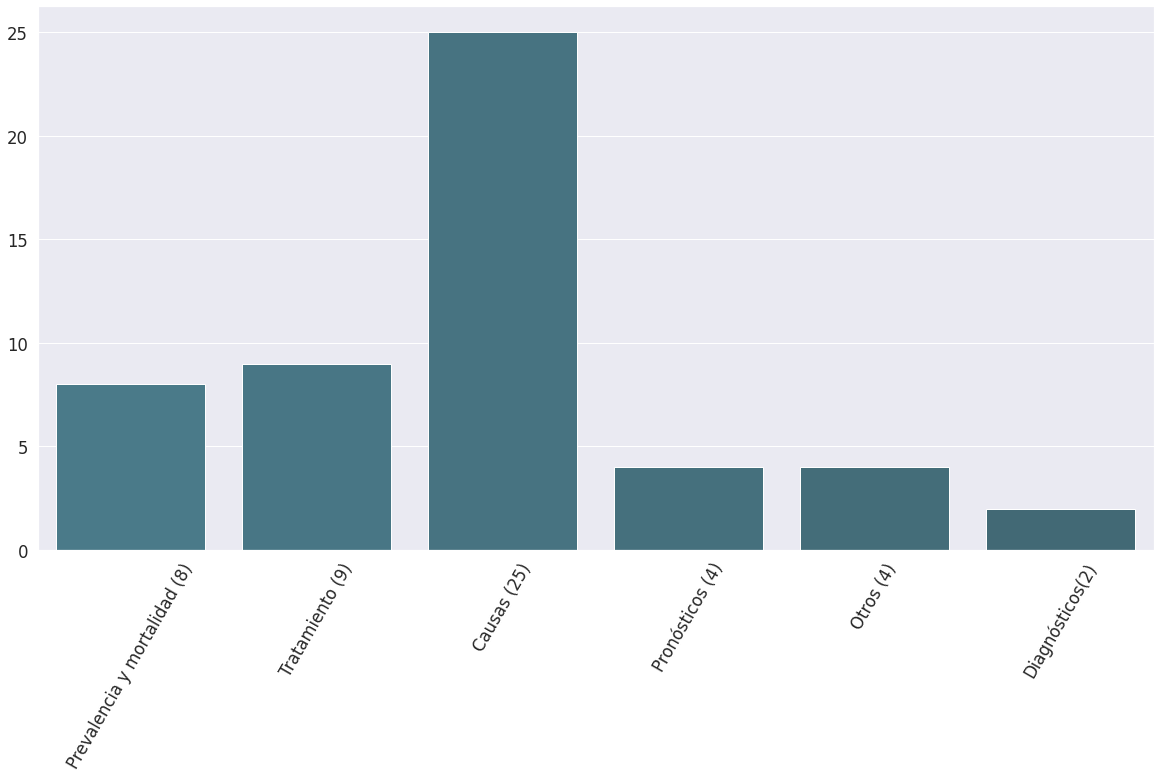

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale = 1.5)
g = sns.barplot(['Prevalencia y mortalidad (8)',
 'Tratamiento (9)',
 'Causas (25)',
 'Pronósticos (4)',
 'Otros (4)',
 'Diagnósticos(2)'],[8,9,25,4,4,2], palette =sns.diverging_palette(220, 20, n=50, center = "dark"))
plt.xticks(rotation=60)
plt.show()

In [118]:
categories_count = [46093,14004,115301,19070,8758,12758]
for n in range(len(hoax_categories)):
  print(hoax_categories[n],': ',categories_count[n]/sum(categories_count))

Prevalence and mortality :  0.21340932661678644
Alternative Treatment :  0.06483813615823394
Causes :  0.5338404696644196
Medical prognosis :  0.08829357730202238
Other :  0.04054929994814431
Diagnosis :  0.059069190310393364


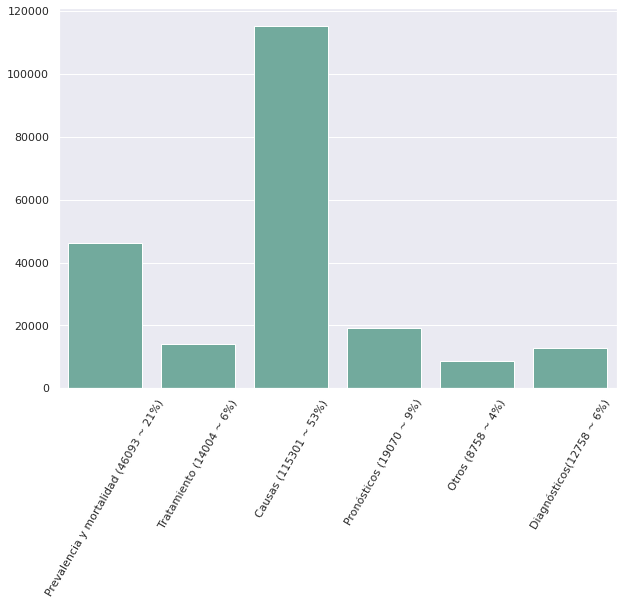

In [119]:

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# load dataset
tips = sns.load_dataset("tips")

# Set the figure size
plt.figure(figsize=(10, 7))

# plot a bar chart
sns.barplot(
    x=['Prevalencia y mortalidad (46093 ~ 21%)',
 'Tratamiento (14004 ~ 6%)',
 'Causas (115301 ~ 53%)',
 'Pronósticos (19070 ~ 9%)',
 'Otros (8758 ~ 4%)',
 'Diagnósticos(12758 ~ 6%)'], 
    y=[46093,14004,115301,19070,8758,12758], 
    data=tips, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');
plt.xticks(rotation=60)
plt.show()

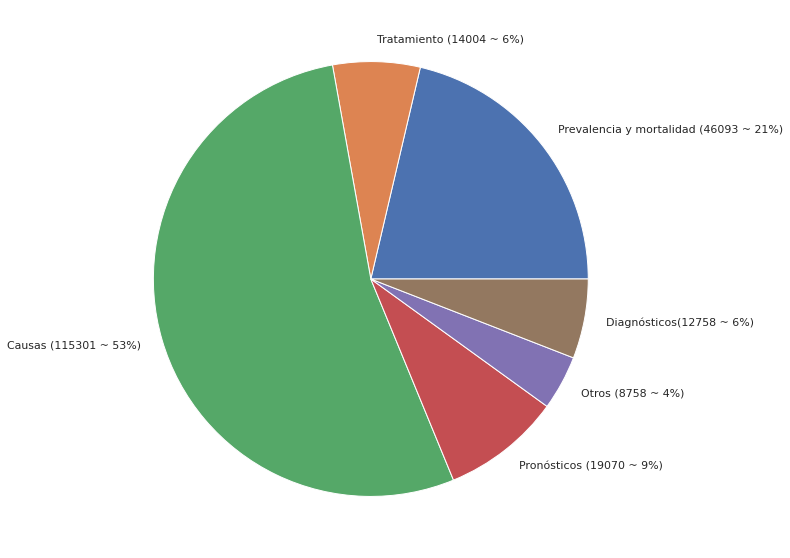

In [120]:
y = np.array([46093,14004,115301,19070,8758,12758])
labels = ['Prevalencia y mortalidad (46093 ~ 21%)',
 'Tratamiento (14004 ~ 6%)',
 'Causas (115301 ~ 53%)',
 'Pronósticos (19070 ~ 9%)',
 'Otros (8758 ~ 4%)',
 'Diagnósticos(12758 ~ 6%)']

plt.pie(y, labels = labels)
plt.show() 

In [123]:
finalreport_enriched_queries

,index,Hoax,query,tweet count,Hoax type,Cancer type,Entailment count,"Sentiment Analysis(postive, neutral, negative)","Emotion Analysis(joy,optimism, sadness, anger)",positives_count,negatives_count,neutrals_count,joy_count,optimism_count,sadness_count,anger_count
0,0,huge spike in soft-tissue cancers diagnoses in...,(((2021 OR 2.021)) spike vaccines huge cancers...,36468,Prevalence and mortality,General,13961.0,"[1200, 3264, 9497]","[2057, 2031, 4632, 5241]",1200.0,9497.0,3264.0,2057.0,2031.0,4632.0,5241.0
1,1,Cancer institute finally admits marijuana kill...,(marijuana finally (kills OR admits) (cancer O...,566,Treatment,General,160.0,"[89, 51, 20]","[54, 61, 15, 30]",89.0,20.0,51.0,54.0,61.0,15.0,30.0
2,2,No one has died of cancer or heart disease sin...,(since one cancer heart (started OR died) covi...,4573,Prevalence and mortality,General,1594.0,"[529, 327, 738]","[367, 412, 117, 698]",529.0,738.0,327.0,367.0,412.0,117.0,698.0
3,3,80% of children born in developing countries d...,((80%) countries cancer children (developing O...,38455,Prevalence and mortality,General,6657.0,"[712, 1230, 4715]","[621, 779, 3214, 2043]",712.0,4715.0,1230.0,621.0,779.0,3214.0,2043.0
4,4,Cutting out sugar and drinking hot lemon water...,(hot water sugar cancer lemon (drinking OR cur...,318,Treatment,General,131.0,"[57, 40, 34]","[30, 46, 23, 32]",57.0,34.0,40.0,30.0,46.0,23.0,32.0
5,5,Abortion increases the risk of breast cancer.,(abortion risk breast cancer increases) OR (ha...,16555,Causes,Breast,1989.0,"[331, 621, 1037]","[137, 147, 548, 1157]",331.0,1037.0,621.0,137.0,147.0,548.0,1157.0
6,6,The flu shot is designed to spread cancer.,(flu cancer shot (designed OR spread)) OR (hum...,27174,Causes,General,6784.0,"[398, 1531, 4855]","[573, 360, 2358, 3493]",398.0,4855.0,1531.0,573.0,360.0,2358.0,3493.0
7,7,Dandelion root is able to kill 98% of cancer c...,"(((""forty-eight"" OR 48) OR 98%) hours dandelio...",513,Treatment,General,89.0,"[58, 22, 9]","[26, 36, 11, 16]",58.0,9.0,22.0,26.0,36.0,11.0,16.0
8,8,A molecule found in a Himalayan fungus kills c...,"(((""forty"" OR 40)) molecule cells fungus poten...",99,Treatment,General,59.0,"[28, 17, 14]","[18, 26, 11, 4]",28.0,14.0,17.0,18.0,26.0,11.0,4.0
9,9,Cancer and matters to do with kidney failure k...,(tuberculosis malaria cancer kidney aids kill ...,4103,Prevalence and mortality,General,994.0,"[59, 262, 673]","[98, 61, 501, 334]",59.0,673.0,262.0,98.0,61.0,501.0,334.0


## Sentiment analysis

In [470]:
positives_count = []
neutrals_count = []
negatives_count = []
for n in tqdm(range(52)):
  pos_count = finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'][n][0]
  neu_count = finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'][n][1]
  neg_count = finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'][n][2]
  positives_count.append(pos_count)
  neutrals_count.append(neu_count)
  negatives_count.append(neg_count)

100%|██████████| 52/52 [00:00<00:00, 15285.15it/s]


In [474]:
while len(finalreport_enriched_queries) != len(positives_count):
  positives_count.append(np.nan)

while len(finalreport_enriched_queries) != len(negatives_count):
  negatives_count.append(np.nan)

while len(finalreport_enriched_queries) != len(neutrals_count):
  neutrals_count.append(np.nan)

In [475]:
finalreport_enriched_queries['positives_count'] = positives_count
finalreport_enriched_queries['negatives_count'] = negatives_count
finalreport_enriched_queries['neutrals_count'] = neutrals_count

In [125]:
finalreport_enriched_queries

,index,Hoax,query,tweet count,Hoax type,Cancer type,Entailment count,"Sentiment Analysis(postive, neutral, negative)","Emotion Analysis(joy,optimism, sadness, anger)",positives_count,negatives_count,neutrals_count,joy_count,optimism_count,sadness_count,anger_count
0,0,huge spike in soft-tissue cancers diagnoses in...,(((2021 OR 2.021)) spike vaccines huge cancers...,36468,Prevalence and mortality,General,13961.0,"[1200, 3264, 9497]","[2057, 2031, 4632, 5241]",1200.0,9497.0,3264.0,2057.0,2031.0,4632.0,5241.0
1,1,Cancer institute finally admits marijuana kill...,(marijuana finally (kills OR admits) (cancer O...,566,Treatment,General,160.0,"[89, 51, 20]","[54, 61, 15, 30]",89.0,20.0,51.0,54.0,61.0,15.0,30.0
2,2,No one has died of cancer or heart disease sin...,(since one cancer heart (started OR died) covi...,4573,Prevalence and mortality,General,1594.0,"[529, 327, 738]","[367, 412, 117, 698]",529.0,738.0,327.0,367.0,412.0,117.0,698.0
3,3,80% of children born in developing countries d...,((80%) countries cancer children (developing O...,38455,Prevalence and mortality,General,6657.0,"[712, 1230, 4715]","[621, 779, 3214, 2043]",712.0,4715.0,1230.0,621.0,779.0,3214.0,2043.0
4,4,Cutting out sugar and drinking hot lemon water...,(hot water sugar cancer lemon (drinking OR cur...,318,Treatment,General,131.0,"[57, 40, 34]","[30, 46, 23, 32]",57.0,34.0,40.0,30.0,46.0,23.0,32.0
5,5,Abortion increases the risk of breast cancer.,(abortion risk breast cancer increases) OR (ha...,16555,Causes,Breast,1989.0,"[331, 621, 1037]","[137, 147, 548, 1157]",331.0,1037.0,621.0,137.0,147.0,548.0,1157.0
6,6,The flu shot is designed to spread cancer.,(flu cancer shot (designed OR spread)) OR (hum...,27174,Causes,General,6784.0,"[398, 1531, 4855]","[573, 360, 2358, 3493]",398.0,4855.0,1531.0,573.0,360.0,2358.0,3493.0
7,7,Dandelion root is able to kill 98% of cancer c...,"(((""forty-eight"" OR 48) OR 98%) hours dandelio...",513,Treatment,General,89.0,"[58, 22, 9]","[26, 36, 11, 16]",58.0,9.0,22.0,26.0,36.0,11.0,16.0
8,8,A molecule found in a Himalayan fungus kills c...,"(((""forty"" OR 40)) molecule cells fungus poten...",99,Treatment,General,59.0,"[28, 17, 14]","[18, 26, 11, 4]",28.0,14.0,17.0,18.0,26.0,11.0,4.0
9,9,Cancer and matters to do with kidney failure k...,(tuberculosis malaria cancer kidney aids kill ...,4103,Prevalence and mortality,General,994.0,"[59, 262, 673]","[98, 61, 501, 334]",59.0,673.0,262.0,98.0,61.0,501.0,334.0


In [479]:
joy_count = []
optimism_count = []
sadness_count = []
anger_count = []
for n in range(52):
  joy_hoax = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][n][0]
  optimism_hoax = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][n][1]
  sadness_hoax = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][n][2]
  anger_hoax = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][n][3]
  joy_count.append(joy_hoax)
  optimism_count.append(optimism_hoax)
  sadness_count.append(sadness_hoax)
  anger_count.append(anger_hoax)



In [481]:
while len(finalreport_enriched_queries) != len(joy_count):
  joy_count.append(np.nan)

while len(finalreport_enriched_queries) != len(optimism_count):
  optimism_count.append(np.nan)

while len(finalreport_enriched_queries) != len(sadness_count):
  sadness_count.append(np.nan)

while len(finalreport_enriched_queries) != len(anger_count):
  anger_count.append(np.nan)

In [482]:
finalreport_enriched_queries['joy_count'] = joy_count
finalreport_enriched_queries['optimism_count'] = optimism_count
finalreport_enriched_queries['sadness_count'] = sadness_count
finalreport_enriched_queries['anger_count'] = anger_count

In [44]:
finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'][52]

[26853, 88876, 100255]

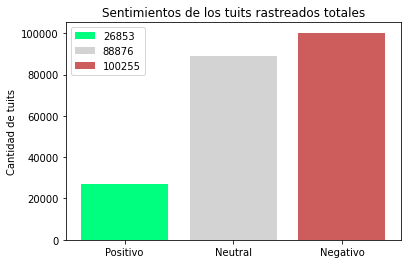

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
bar_width = 0.2
opacity = 0.4
#bar plot
ax.bar('Positivo', height =26853, color = 'springgreen')
ax.bar('Neutral',88876, color= 'lightgrey')
ax.bar('Negativo', height =100255, color = 'indianred')

plt.ylabel('Cantidad de tuits')
plt.title("Sentimientos de los tuits rastreados totales")
plt.legend([26853, 88876, 100255],loc=2)

plt.show()

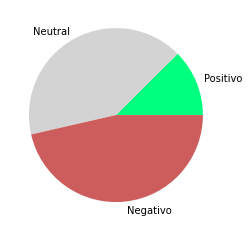

In [71]:
y = np.array([26853, 88876, 100255])
labels = ['Positivo', 'Neutral', 'Negativo']

plt.pie(y, labels = labels, colors=['springgreen', 'lightgrey', 'indianred'])
plt.show() 

In [130]:
hoax_categories = list(finalreport_enriched_queries['Hoax type'][:52].unique())

In [131]:
hoax_categories

['Prevalence and mortality',
 'Treatment',
 'Causes',
 'Medical prognosis',
 'Other',
 'Diagnosis']

In [205]:
for category in hoax_categories:
  filteredreport = finalreport_enriched_queries[finalreport_enriched_queries['Hoax type'] == category]
  positives_count = filteredreport['positives_count'].sum()
  neutrals_count = filteredreport['neutrals_count'].sum()
  negatives_count = filteredreport['negatives_count'].sum()
  sentiments_list = [positives_count, neutrals_count, negatives_count]
  print("for category: {}, the amount of tweets tracked were classified in positive, neutral and negative polarity:{} ".format(category, sentiments_list))

for category: Prevalence and mortality, the amount of tweets tracked were classified in positive, neutral and negative polarity:[10685.0, 15581.0, 19827.0] 
for category: Treatment, the amount of tweets tracked were classified in positive, neutral and negative polarity:[2079.0, 4539.0, 7386.0] 
for category: Causes, the amount of tweets tracked were classified in positive, neutral and negative polarity:[9711.0, 50140.0, 55450.0] 
for category: Medical prognosis, the amount of tweets tracked were classified in positive, neutral and negative polarity:[1739.0, 8900.0, 8431.0] 
for category: Other, the amount of tweets tracked were classified in positive, neutral and negative polarity:[1380.0, 4657.0, 2721.0] 
for category: Diagnosis, the amount of tweets tracked were classified in positive, neutral and negative polarity:[1259.0, 5059.0, 6440.0] 


In [142]:
data =  {
            'Prevalence and mortality':[10685.0, 15581.0, 19827.0],
            'Treatment':[2079.0, 4539.0, 7386.0],
            'Causes':[9711.0, 50140.0, 55450.0],
            'Medical prognosis':[1739.0, 8900.0, 8431.0],
            'Other':[1380.0, 4657.0, 2721.0],
            'Diagnosis':[1259.0, 5059.0, 6440.0]
}


for category in hoax_categories:
  sentiment_list = data[category]
  total = sum(sentiment_list)
  positive_percentage = sentiment_list[0]/total
  neutral_percentage = sentiment_list[1]/total
  negative_percentage = sentiment_list[2]/total
  print("""Category: {}
  -------------------------------------""".format(category))
  print("For cateogry {}, the percetage of tuits with positive sentiment over the total is {}".format(category, positive_percentage))
  print("For cateogry {}, the percetage of tuits with neutral sentiment over the total is {}".format(category, neutral_percentage))
  print("For cateogry {}, the percetage of tuits with negative sentiment over the total is {}".format(category, negative_percentage))

Category: Prevalence and mortality
  -------------------------------------
For cateogry Prevalence and mortality, the percetage of tuits with positive sentiment over the total is 0.23181394137938516
For cateogry Prevalence and mortality, the percetage of tuits with neutral sentiment over the total is 0.3380339747900983
For cateogry Prevalence and mortality, the percetage of tuits with negative sentiment over the total is 0.43015208383051656
Category: Treatment
  -------------------------------------
For cateogry Treatment, the percetage of tuits with positive sentiment over the total is 0.14845758354755784
For cateogry Treatment, the percetage of tuits with neutral sentiment over the total is 0.3241216795201371
For cateogry Treatment, the percetage of tuits with negative sentiment over the total is 0.5274207369323051
Category: Causes
  -------------------------------------
For cateogry Causes, the percetage of tuits with positive sentiment over the total is 0.08422303362503361
For cate

In [152]:
from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
    plt.xticks(range(3), ['Positivo', 'Neutral', 'Negativo'], color='Black', fontsize=16)
    
    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(),prop={'size': 16})



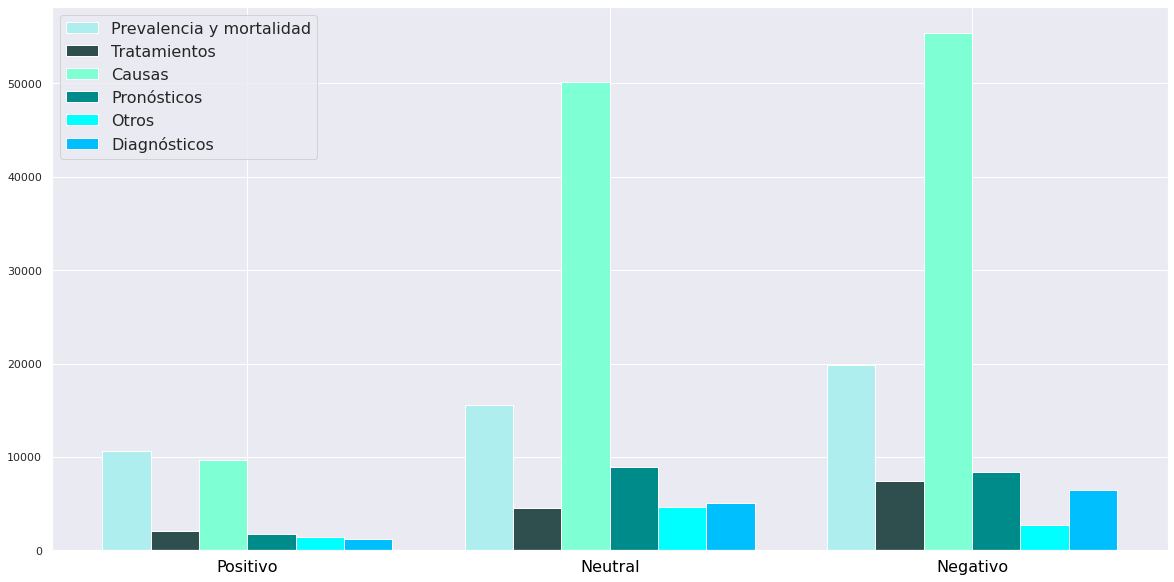

In [153]:
from matplotlib.pyplot import figure
data =  {
            "Prevalencia y mortalidad":[10685.0, 15581.0, 19827.0],
            "Tratamientos":[2079.0, 4539.0, 7386.0],
            "Causas":[9711.0, 50140.0, 55450.0],
            "Pronósticos":[1739.0, 8900.0, 8431.0],
            "Otros":[1380.0, 4657.0, 2721.0],
            "Diagnósticos":[1259.0, 5059.0, 6440.0]
        }
        
colors = ['paleturquoise', 'darkslategray', 'aquamarine', 'darkcyan', 'cyan', 'deepskyblue']
fig, ax = plt.subplots()

bar_plot(ax=ax, data=data, colors=colors, total_width=0.8, single_width=1, legend=True)

In [132]:
hoax_categories

['Prevalence and mortality',
 'Treatment',
 'Causes',
 'Medical prognosis',
 'Other',
 'Diagnosis']

In [160]:
#storing indexes of hoax which max sentiment is positive
idx_max_positive_Sent = []  
for n in range(52):
  sent_list = finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'][n]
  max_value = max(sent_list)
  max_index = sent_list.index(max_value)
  if max_index == 0:
    idx_max_positive_Sent.append(n)

In [166]:
list(finalreport_enriched_queries['Hoax'].iloc[idx_max_positive_Sent])

['Cancer institute finally admits marijuana kills cancer.',
 'Cutting out sugar and drinking hot lemon water will cure cancer. ',
 'Dandelion root is able to kill 98% of cancer cells within 48 hours.',
 'A molecule found in a Himalayan fungus kills cancer cells with 40 times potency.',
 'Rubbing hydrogen peroxide over your body every day treat cancer',
 'You won’t need surgery if the tumor is solid',
 'Oncologists don’t want patients trying experimental treatments',
 'Herbal medicines can cure cancer']

In [167]:
list(finalreport_enriched_queries['Sentiment Analysis(postive, neutral, negative)'].iloc[idx_max_positive_Sent])

[[89, 51, 20],
 [57, 40, 34],
 [58, 22, 9],
 [28, 17, 14],
 [18, 12, 4],
 [676, 514, 262],
 [0, 0, 0],
 [1050, 811, 259]]

In [185]:
finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])

,index,Hoax,query,tweet count,Hoax type,Cancer type,Entailment count,"Sentiment Analysis(postive, neutral, negative)","Emotion Analysis(joy,optimism, sadness, anger)",positives_count,negatives_count,neutrals_count,joy_count,optimism_count,sadness_count,anger_count
50,50,Mammograms cause breast cancer to spread,(breast cancer mammograms (spread OR cause)) O...,46221,Causes,Breast,18169.0,"[997, 5390, 11782]","[1001, 814, 3911, 12443]",997.0,11782.0,5390.0,1001.0,814.0,3911.0,12443.0
49,49,Men do not get breast cancer,(men cancer breast get) OR (counterpart male b...,32801,Prevalence and mortality,Breast,17140.0,"[6369, 7630, 3141]","[6407, 5967, 832, 3934]",6369.0,3141.0,7630.0,6407.0,5967.0,832.0,3934.0
25,25,Eating burnt foods cause cancer,(cancer foods (cause OR eating OR burnt)) OR (...,49876,Causes,General,15928.0,"[1658, 10247, 4023]","[1183, 2655, 4552, 7538]",1658.0,4023.0,10247.0,1183.0,2655.0,4552.0,7538.0
10,10,Polio vaccine cause cancer,(vaccine cancer polio cause) OR (vaccination r...,38761,Causes,General,14896.0,"[1451, 4029, 9416]","[647, 1257, 5733, 7259]",1451.0,9416.0,4029.0,647.0,1257.0,5733.0,7259.0
0,0,huge spike in soft-tissue cancers diagnoses in...,(((2021 OR 2.021)) spike vaccines huge cancers...,36468,Prevalence and mortality,General,13961.0,"[1200, 3264, 9497]","[2057, 2031, 4632, 5241]",1200.0,9497.0,3264.0,2057.0,2031.0,4632.0,5241.0
24,24,Phones cause cancer,(phones cancer cause) OR (smartphones cancerou...,43983,Causes,General,12816.0,"[210, 8676, 3930]","[1010, 2323, 3695, 5788]",210.0,3930.0,8676.0,1010.0,2323.0,3695.0,5788.0
19,19,A lump in your breast is always breast cancer,(lump always breast cancer) OR (breast also ca...,34875,Diagnosis,Breast,12600.0,"[1226, 4979, 6395]","[318, 1084, 6306, 4892]",1226.0,6395.0,4979.0,318.0,1084.0,6306.0,4892.0
37,37,There is no cure for cancer,(cancer cure) OR (curable tumors) OR (cancer d...,44976,Treatment,General,9453.0,"[684, 2263, 6506]","[922, 1135, 4797, 2599]",684.0,6506.0,2263.0,922.0,1135.0,4797.0,2599.0
34,34,Cancer surgery causes cancer to spread,(surgery cancer (spread OR causes)) OR (produc...,41673,Causes,General,8431.0,"[430, 3848, 4153]","[606, 1334, 2688, 3803]",430.0,4153.0,3848.0,606.0,1334.0,2688.0,3803.0
22,22,Cancer will always come back,(back always cancer come) OR (cancer never ret...,49654,Medical prognosis,General,8304.0,"[599, 4805, 2900]","[233, 2313, 4627, 1131]",599.0,2900.0,4805.0,233.0,2313.0,4627.0,1131.0


In [176]:
top_polemic_hoaxes = list(finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])['Hoax'][:10])

In [181]:
top_polemic_hoaxes

['Mammograms cause breast cancer to spread',
 'Men do not get breast cancer',
 'Eating burnt foods cause cancer ',
 'Polio vaccine cause cancer',
 'huge spike in soft-tissue cancers diagnoses in 2021 as a result of COVID-19 vaccines',
 'Phones cause cancer',
 'A lump in your breast is always breast cancer',
 'There is no cure for cancer',
 'Cancer surgery causes cancer to spread',
 'Cancer will always come back']

In [179]:
sentiment_top_polemic_hoaxes = list(finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])['Sentiment Analysis(postive, neutral, negative)'][:10])

In [182]:
sentiment_top_polemic_hoaxes

[[997, 5390, 11782],
 [6369, 7630, 3141],
 [1658, 10247, 4023],
 [1451, 4029, 9416],
 [1200, 3264, 9497],
 [210, 8676, 3930],
 [1226, 4979, 6395],
 [684, 2263, 6506],
 [430, 3848, 4153],
 [599, 4805, 2900]]

In [180]:
entailment_count_top_polemic_hoaxes = list(finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])['Entailment count'][:10])

In [183]:
entailment_count_top_polemic_hoaxes

[18169.0,
 17140.0,
 15928.0,
 14896.0,
 13961.0,
 12816.0,
 12600.0,
 9453.0,
 8431.0,
 8304.0]

## Emotion analisis

In [186]:
finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52]

[23743, 34566, 75915, 81760]

In [199]:
sum(finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52])

215984

In [203]:
# getting porcentages of emotions in total tracked tweets
joy_percentage = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52][0]/sum(finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52])
optimism_percentage = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52][1]/sum(finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52])
sadness_percentage = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52][2]/sum(finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52])
anger_percentage = finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52][3]/sum(finalreport_enriched_queries['Emotion Analysis(joy,optimism, sadness, anger)'][52])

In [204]:
print("joy_percentage: ",joy_percentage)
print("optimism_percentage: ",optimism_percentage)
print("sadness_percentage: ",sadness_percentage)
print("anger_percentage: ",anger_percentage)

joy_percentage:  0.10992943921771983
optimism_percentage:  0.1600396325653752
sadness_percentage:  0.3514843692125343
anger_percentage:  0.3785465590043707


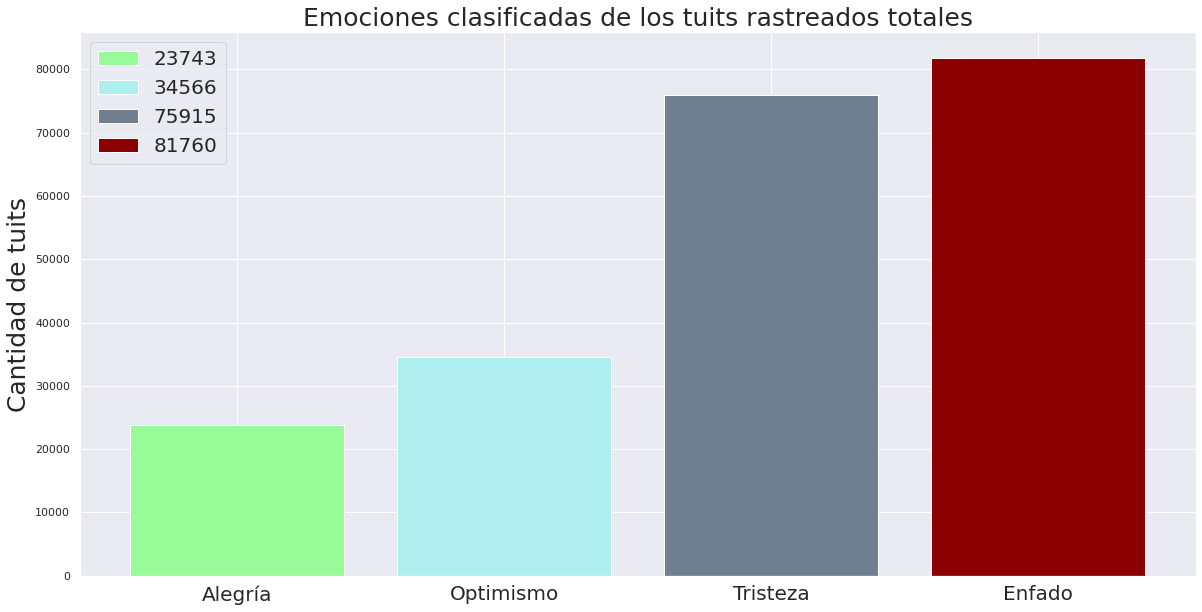

In [198]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
bar_width = 0.2
opacity = 0.4
#bar plot
ax.bar('Alegría', height =23743, color = 'palegreen')
ax.bar('Optimismo',34566, color= 'paleturquoise')
ax.bar('Tristeza', height =75915, color = 'slategrey')
ax.bar('Enfado', height =81760, color = 'darkred')

plt.ylabel('Cantidad de tuits',fontsize = 25)
plt.title("Emociones clasificadas de los tuits rastreados totales",fontsize = 25 )
plt.xticks(fontsize = 20)
plt.legend([23743, 34566, 75915, 81760],loc=2, prop={'size': 20})


plt.show()

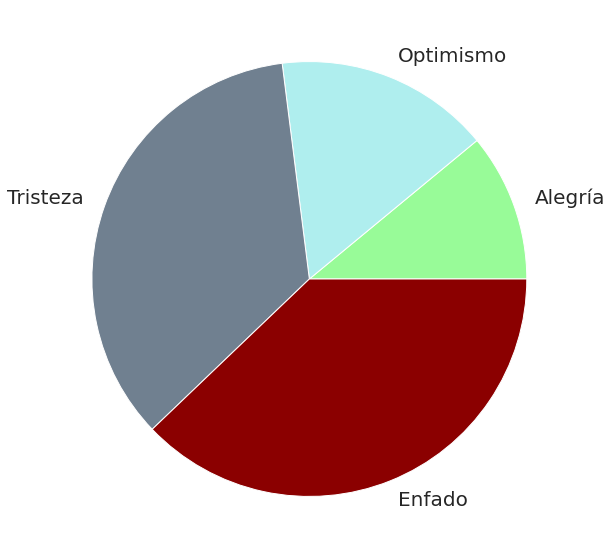

In [196]:
y = np.array([23743, 34566, 75915, 81760])
labels = ['Alegría', 'Optimismo', 'Tristeza', 'Enfado']

plt.pie(y, labels = labels, colors=['palegreen', 'paleturquoise', 'slategrey', 'darkred'],textprops={'fontsize': 20})
plt.show() 

In [206]:
hoax_categories = list(finalreport_enriched_queries['Hoax type'][:52].unique())

In [207]:
hoax_categories

['Prevalence and mortality',
 'Treatment',
 'Causes',
 'Medical prognosis',
 'Other',
 'Diagnosis']

In [209]:

for category in hoax_categories:
  filteredreport = finalreport_enriched_queries[finalreport_enriched_queries['Hoax type'] == category]
  #Counts by category
  joy_count = filteredreport['joy_count'].sum()
  optimism_count = filteredreport['optimism_count'].sum()
  sadness_count = filteredreport['sadness_count'].sum()
  anger_count = filteredreport['anger_count'].sum()
  emotions_list = [joy_count,optimism_count, sadness_count,anger_count]
  # perccentages by category
  joy_percentage = joy_count/sum(emotions_list)
  optimism_percentage = optimism_count/sum(emotions_list)
  sadness_percentage = sadness_count/sum(emotions_list)
  anger_percentage = anger_count/sum(emotions_list)
  percentages_list = [joy_percentage, optimism_percentage, sadness_percentage, anger_percentage]
  print("for category: {}, the amount of tweets tracked were classified in joy, optimism, sadness and anger polarity:{}, percentages: {}".format(category, emotions_list, percentages_list))

for category: Prevalence and mortality, the amount of tweets tracked were classified in joy, optimism, sadness and anger polarity:[10349.0, 10966.0, 10592.0, 14186.0], percentages: [0.22452433124335583, 0.2379103117610049, 0.2297962814310199, 0.30776907556461935]
for category: Treatment, the amount of tweets tracked were classified in joy, optimism, sadness and anger polarity:[2720.0, 2304.0, 5869.0, 3111.0], percentages: [0.1942302199371608, 0.16452442159383032, 0.4190945444158812, 0.22215081405312767]
for category: Causes, the amount of tweets tracked were classified in joy, optimism, sadness and anger polarity:[8258.0, 14195.0, 37737.0, 55111.0], percentages: [0.07162123485485815, 0.12311254889376501, 0.32729117700627053, 0.4779750392451063]
for category: Medical prognosis, the amount of tweets tracked were classified in joy, optimism, sadness and anger polarity:[641.0, 3611.0, 12622.0, 2196.0], percentages: [0.033613004719454644, 0.18935500786575774, 0.6618772941793393, 0.115154693

In [224]:
data =  {
            'Prevalence and mortality':[10349.0, 10966.0, 10592.0, 14186.0],
            'Treatment':[2720.0, 2304.0, 5869.0, 3111.0],
            'Causes':[8258.0, 14195.0, 37737.0, 55111.0],
            'Medical prognosis':[641.0, 3611.0, 12622.0, 2196.0],
            'Other':[1423.0, 2300.0, 2780.0, 2255.0],
            'Diagnosis':[352.0, 1190.0, 6315.0, 4901.0]
        }
        


for category in hoax_categories:
  emotion_list = data[category]
  total = sum(emotion_list)
  joy_percentage = emotion_list[0]/total
  optimism_percentage = emotion_list[1]/total
  sadness_percentage = emotion_list[2]/total
  anger_percentage = emotion_list[2]/total
  print("""Category: {}
  -------------------------------------""".format(category))
  print("For cateogry {}, the percetage of tuits with joy emotion over the total is {}".format(category, joy_percentage))
  print("For cateogry {}, the percetage of tuits with optimism emotion over the total is {}".format(category, optimism_percentage))
  print("For cateogry {}, the percetage of tuits with sadness emotion over the total is {}".format(category, sadness_percentage))
  print("For cateogry {}, the percetage of tuits with anger emotion over the total is {}".format(category, anger_percentage))

Category: Prevalence and mortality
  -------------------------------------
For cateogry Prevalence and mortality, the percetage of tuits with joy emotion over the total is 0.22452433124335583
For cateogry Prevalence and mortality, the percetage of tuits with optimism emotion over the total is 0.2379103117610049
For cateogry Prevalence and mortality, the percetage of tuits with sadness emotion over the total is 0.2297962814310199
For cateogry Prevalence and mortality, the percetage of tuits with anger emotion over the total is 0.2297962814310199
Category: Treatment
  -------------------------------------
For cateogry Treatment, the percetage of tuits with joy emotion over the total is 0.1942302199371608
For cateogry Treatment, the percetage of tuits with optimism emotion over the total is 0.16452442159383032
For cateogry Treatment, the percetage of tuits with sadness emotion over the total is 0.4190945444158812
For cateogry Treatment, the percetage of tuits with anger emotion over the t

In [216]:
from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
    plt.xticks(range(4), ['Alegría', 'Optimismo', 'Tristeza', 'Enfado'], color='Black', fontsize=16)
    
    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(),prop={'size': 16})



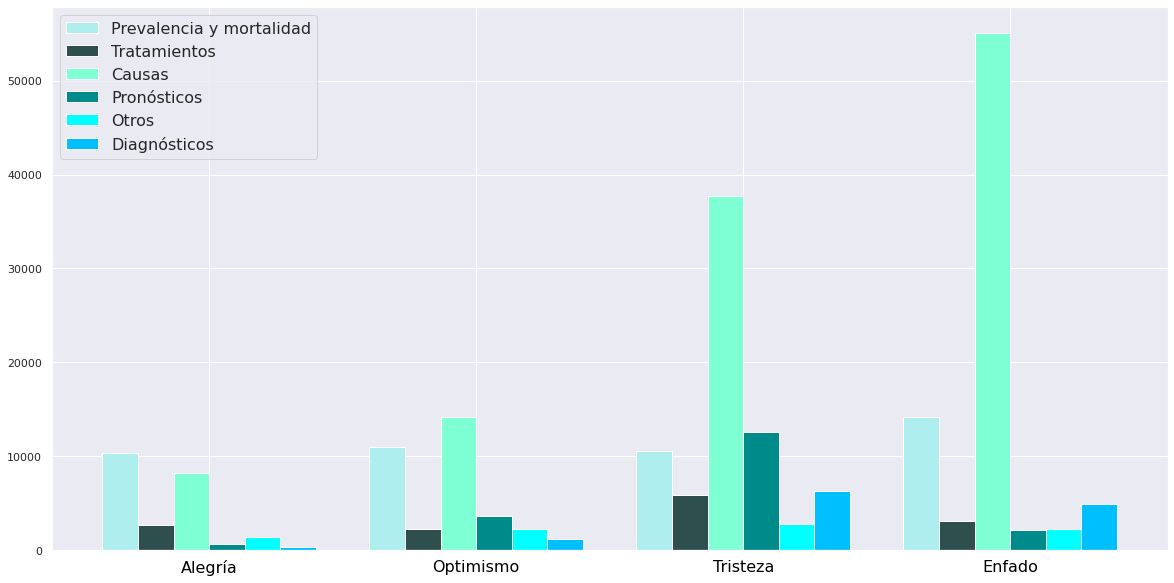

In [217]:
from matplotlib.pyplot import figure
data =  {
            "Prevalencia y mortalidad":[10349.0, 10966.0, 10592.0, 14186.0],
            "Tratamientos":[2720.0, 2304.0, 5869.0, 3111.0],
            "Causas":[8258.0, 14195.0, 37737.0, 55111.0],
            "Pronósticos":[641.0, 3611.0, 12622.0, 2196.0],
            "Otros":[1423.0, 2300.0, 2780.0, 2255.0],
            "Diagnósticos":[352.0, 1190.0, 6315.0, 4901.0]
        }
        
colors = ['paleturquoise', 'darkslategray', 'aquamarine', 'darkcyan', 'cyan', 'deepskyblue']
fig, ax = plt.subplots()

bar_plot(ax=ax, data=data, colors=colors, total_width=0.8, single_width=1, legend=True)

In [ ]:
hoax_categories

['Prevalence and mortality',
 'Treatment',
 'Causes',
 'Medical prognosis',
 'Other',
 'Diagnosis']

In [ ]:
finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])

,index,Hoax,query,tweet count,Hoax type,Cancer type,Entailment count,"Sentiment Analysis(postive, neutral, negative)","Emotion Analysis(joy,optimism, sadness, anger)",positives_count,negatives_count,neutrals_count,joy_count,optimism_count,sadness_count,anger_count
50,50,Mammograms cause breast cancer to spread,(breast cancer mammograms (spread OR cause)) O...,46221,Causes,Breast,18169.0,"[997, 5390, 11782]","[1001, 814, 3911, 12443]",997.0,11782.0,5390.0,1001.0,814.0,3911.0,12443.0
49,49,Men do not get breast cancer,(men cancer breast get) OR (counterpart male b...,32801,Prevalence and mortality,Breast,17140.0,"[6369, 7630, 3141]","[6407, 5967, 832, 3934]",6369.0,3141.0,7630.0,6407.0,5967.0,832.0,3934.0
25,25,Eating burnt foods cause cancer,(cancer foods (cause OR eating OR burnt)) OR (...,49876,Causes,General,15928.0,"[1658, 10247, 4023]","[1183, 2655, 4552, 7538]",1658.0,4023.0,10247.0,1183.0,2655.0,4552.0,7538.0
10,10,Polio vaccine cause cancer,(vaccine cancer polio cause) OR (vaccination r...,38761,Causes,General,14896.0,"[1451, 4029, 9416]","[647, 1257, 5733, 7259]",1451.0,9416.0,4029.0,647.0,1257.0,5733.0,7259.0
0,0,huge spike in soft-tissue cancers diagnoses in...,(((2021 OR 2.021)) spike vaccines huge cancers...,36468,Prevalence and mortality,General,13961.0,"[1200, 3264, 9497]","[2057, 2031, 4632, 5241]",1200.0,9497.0,3264.0,2057.0,2031.0,4632.0,5241.0
24,24,Phones cause cancer,(phones cancer cause) OR (smartphones cancerou...,43983,Causes,General,12816.0,"[210, 8676, 3930]","[1010, 2323, 3695, 5788]",210.0,3930.0,8676.0,1010.0,2323.0,3695.0,5788.0
19,19,A lump in your breast is always breast cancer,(lump always breast cancer) OR (breast also ca...,34875,Diagnosis,Breast,12600.0,"[1226, 4979, 6395]","[318, 1084, 6306, 4892]",1226.0,6395.0,4979.0,318.0,1084.0,6306.0,4892.0
37,37,There is no cure for cancer,(cancer cure) OR (curable tumors) OR (cancer d...,44976,Treatment,General,9453.0,"[684, 2263, 6506]","[922, 1135, 4797, 2599]",684.0,6506.0,2263.0,922.0,1135.0,4797.0,2599.0
34,34,Cancer surgery causes cancer to spread,(surgery cancer (spread OR causes)) OR (produc...,41673,Causes,General,8431.0,"[430, 3848, 4153]","[606, 1334, 2688, 3803]",430.0,4153.0,3848.0,606.0,1334.0,2688.0,3803.0
22,22,Cancer will always come back,(back always cancer come) OR (cancer never ret...,49654,Medical prognosis,General,8304.0,"[599, 4805, 2900]","[233, 2313, 4627, 1131]",599.0,2900.0,4805.0,233.0,2313.0,4627.0,1131.0


In [ ]:
top_polemic_hoaxes = list(finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])['Hoax'][:10])

In [218]:
top_polemic_hoaxes

['Mammograms cause breast cancer to spread',
 'Men do not get breast cancer',
 'Eating burnt foods cause cancer ',
 'Polio vaccine cause cancer',
 'huge spike in soft-tissue cancers diagnoses in 2021 as a result of COVID-19 vaccines',
 'Phones cause cancer',
 'A lump in your breast is always breast cancer',
 'There is no cure for cancer',
 'Cancer surgery causes cancer to spread',
 'Cancer will always come back']

In [219]:
sentiment_top_polemic_hoaxes = list(finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])['Emotion Analysis(joy,optimism, sadness, anger)'][:10])

In [220]:
sentiment_top_polemic_hoaxes

[[1001, 814, 3911, 12443],
 [6407, 5967, 832, 3934],
 [1183, 2655, 4552, 7538],
 [647, 1257, 5733, 7259],
 [2057, 2031, 4632, 5241],
 [1010, 2323, 3695, 5788],
 [318, 1084, 6306, 4892],
 [922, 1135, 4797, 2599],
 [606, 1334, 2688, 3803],
 [233, 2313, 4627, 1131]]

In [221]:
entailment_count_top_polemic_hoaxes = list(finalreport_enriched_queries.iloc[:52].sort_values(['Entailment count'], ascending=[False])['Entailment count'][:10])

In [222]:
entailment_count_top_polemic_hoaxes

[18169.0,
 17140.0,
 15928.0,
 14896.0,
 13961.0,
 12816.0,
 12600.0,
 9453.0,
 8431.0,
 8304.0]